
# 03 · Multimodal LLM Decoder Training on VALOR (Perceiver Phase‑1 Aligner)

This notebook implements **Notebook 3 – Aligned Model + “Normal” Decoder (standard LLM)**
for the case where your **Phase‑1 aligner is the Perceiver-based `MultimodalAlignmentModel`**.

**What this notebook does:**

1. Loads the **Perceiver Phase‑1 alignment model** (`MultimodalAlignmentModel`) and its checkpoint.
2. Wraps it (plus a frozen CLIP `VisionEncoder`) into a **`PerceiverAlignerForLLM`** that exposes
   the same interface as `VisionTextAligner`:

   - `.cfg.device`, `.cfg.dtype`, `.cfg.d_align`
   - `.encode_vision(images: List[PIL.Image]) -> (B, d_align)`

3. Builds `MultimodalLLM` (Perceiver aligner → LLM prefix → decoder-only LLM).
4. Loads **VALOR instruction-tuning data** from multiple parquet shards, where each row is:
   - `video_id`
   - `caption`
   - `image_jpeg` (frame bytes)
   - `audio_wav`
5. Groups rows by `video_id` into **clip-level samples with multiple frames**.
6. Trains only the **vision→LLM projector** (Phase‑2a) using:

   - **Single-frame mode** per clip: randomly pick one frame per clip every step.

7. Uses **multi-GPU** if available (`nn.DataParallel`).
8. Logs training & evaluation to **Weights & Biases**:
   - Training / validation loss
   - Learning rate
   - Qualitative generations (GT vs generated caption)
9. Saves:

   - `best_phase3_valor_perceiver.pt`
   - `final_phase3_valor_perceiver.pt`

> 🔧 You must edit the paths for:
> - `PHASE1_PERCEIVER_CKPT_PATH`
> - `VALOR_SHARDS_DIR`
> - W&B project / entity (if needed)


## 1. Imports & Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:


import os
import io
import math
import random
import json
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Dict, Any, List, Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import pandas as pd
from PIL import Image as PILImage
from tqdm.auto import tqdm

import wandb

# Project imports
from imports.core import VisionEncoder, set_seed, count_parameters
from imports.llm_integration import LLMConfig, MultimodalLLM
from imports.multimodal_alignment_perceiver import MultimodalAlignmentConfig, MultimodalAlignmentModel


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## 2. Paths & High-Level Configuration

In [3]:

ROOT_DIR = Path.cwd()

# === Phase‑1 Perceiver alignment checkpoint ===
PHASE1_PERCEIVER_CKPT_PATH = ROOT_DIR / "checkpoints" / "phase1_multimodal" / "perceiver_mrl" /"best.pt"  # <-- EDIT

# === VALOR parquet shards (train split) ===
VALOR_SHARDS_DIR = ROOT_DIR / "data" / "alignment_subsets" / "valor32k_train_shards"  # <-- EDIT

assert PHASE1_PERCEIVER_CKPT_PATH.is_file(), f"Phase‑1 Perceiver checkpoint not found: {PHASE1_PERCEIVER_CKPT_PATH}"
assert VALOR_SHARDS_DIR.is_dir(), f"VALOR shards dir not found: {VALOR_SHARDS_DIR}"

print("ROOT_DIR                      :", ROOT_DIR)
print("PHASE1_PERCEIVER_CKPT_PATH    :", PHASE1_PERCEIVER_CKPT_PATH)
print("VALOR_SHARDS_DIR              :", VALOR_SHARDS_DIR)

PHASE3_RUN_NAME = "valor_qwen2p5_phase3_perceiver_v1"
PHASE3_OUT_DIR = ROOT_DIR / "checkpoints" / "phase3_llm_valor_perceiver" / PHASE3_RUN_NAME
PHASE3_OUT_DIR.mkdir(parents=True, exist_ok=True)
print("PHASE3_OUT_DIR                :", PHASE3_OUT_DIR)


ROOT_DIR                      : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base
PHASE1_PERCEIVER_CKPT_PATH    : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase1_multimodal/perceiver_mrl/best.pt
VALOR_SHARDS_DIR              : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/alignment_subsets/valor32k_train_shards
PHASE3_OUT_DIR                : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase3_llm_valor_perceiver/valor_qwen2p5_phase3_perceiver_v1


## 3. Training Hyperparameters & W&B

In [4]:

@dataclass
class Phase3ValorPerceiverConfig:
    # Wandb
    wandb_project: str = "edgeglass_phase1_alignment"
    wandb_run_name: str = PHASE3_RUN_NAME
    wandb_entity: Optional[str] = None  # set if you use a team account

    # LLM
    llm_model_name: str = "Qwen/Qwen2.5-3B-Instruct"
    freeze_llm: bool = True
    num_prefix_tokens: int = 8

    # Data
    max_clips: Optional[int] = None  # cap for debugging; None = all
    val_ratio: float = 0.05
    max_caption_len: int = 96
    frame_limit_per_clip: Optional[int] = None  # e.g. 8; None = all frames

    # Training
    num_epochs: int = 3
    batch_size_per_gpu: int = 2
    learning_rate: float = 5e-5
    weight_decay: float = 0.01
    max_grad_norm: float = 1.0
    warmup_ratio: float = 0.1

    # Logging
    log_every: int = 50
    eval_every: int = 500
    num_eval_samples: int = 8

    # Device / precision
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: str = "bfloat16" if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else "float16"

cfg = Phase3ValorPerceiverConfig()
print(cfg)


Phase3ValorPerceiverConfig(wandb_project='edgeglass_phase1_alignment', wandb_run_name='valor_qwen2p5_phase3_perceiver_v1', wandb_entity=None, llm_model_name='Qwen/Qwen2.5-3B-Instruct', freeze_llm=True, num_prefix_tokens=8, max_clips=None, val_ratio=0.05, max_caption_len=96, frame_limit_per_clip=None, num_epochs=3, batch_size_per_gpu=2, learning_rate=5e-05, weight_decay=0.01, max_grad_norm=1.0, warmup_ratio=0.1, log_every=50, eval_every=500, num_eval_samples=8, seed=42, device='cuda', dtype='bfloat16')


## 4. Device & Seeding

In [5]:

def get_device() -> torch.device:
    return torch.device(cfg.device)

def get_dtype() -> torch.dtype:
    if cfg.dtype == "bfloat16":
        return torch.bfloat16
    if cfg.dtype == "float16":
        return torch.float16
    return torch.float32

set_seed(cfg.seed)
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

device = get_device()
dtype = get_dtype()

print(f"Using device: {device}, dtype: {dtype}")
print(f"GPUs available: {torch.cuda.device_count()}")
if torch.cuda.device_count() > 0:
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")


Using device: cuda, dtype: torch.bfloat16
GPUs available: 2
  GPU 0: NVIDIA H200
  GPU 1: NVIDIA H200


## 5. Load Perceiver Phase‑1 Aligner & Wrap for LLM

In [6]:

from types import SimpleNamespace

# === Build Perceiver alignment model ===
perceiver_cfg = MultimodalAlignmentConfig()
perceiver_model = MultimodalAlignmentModel(perceiver_cfg)

# === Load Phase‑1 checkpoint (generic loader) ===
ckpt = torch.load(PHASE1_PERCEIVER_CKPT_PATH, map_location=device, weights_only=False)
state_dict = None
for key in ["model_state_dict", "alignment_model", "state_dict"]:
    if key in ckpt:
        state_dict = ckpt[key]
        break
if state_dict is None:
    # assume checkpoint is plain state_dict
    state_dict = ckpt

missing, unexpected = perceiver_model.load_state_dict(state_dict, strict=False)
print("Loaded Perceiver Phase‑1 checkpoint.")
print("  Missing keys   :", len(missing))
print("  Unexpected keys:", len(unexpected))

perceiver_model.to(device)
perceiver_model = perceiver_model.to(dtype=dtype)
perceiver_model.eval()
for p in perceiver_model.parameters():
    p.requires_grad = False


def count_parameters(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


print("Perceiver model total params :", count_parameters(perceiver_model))
print("Perceiver model trainable    :", count_parameters(perceiver_model, trainable_only=True))

# === Frozen CLIP vision backbone (same as Phase‑1) ===
vision_backbone = VisionEncoder(
    model_name=perceiver_cfg.vision_model_name,
    device=device,
    dtype=dtype,
)
vision_backbone.eval()
for p in vision_backbone.parameters():
    p.requires_grad = False

print("Vision backbone hidden size:", vision_backbone.hidden_size)


Loaded Perceiver Phase‑1 checkpoint.
  Missing keys   : 149
  Unexpected keys: 6
Perceiver model total params : 21621760
Perceiver model trainable    : 0
[VisionEncoder] Loaded openai/clip-vit-base-patch32, hidden_size=768
Vision backbone hidden size: 768


In [46]:

# === Wrapper aligner with encode_vision(images) & cfg ===
class PerceiverAlignerForLLM(nn.Module):
    def __init__(self, core_model: MultimodalAlignmentModel, vision_encoder: VisionEncoder, device, dtype):
        super().__init__()
        self.core = core_model
        self.vision_encoder = vision_encoder

        # Minimal cfg interface expected by MultimodalLLM
        self.cfg = SimpleNamespace(
            device=device,
            dtype=dtype,
            d_align=core_model.config.d_align,
        )

    def encode_vision(self, images) -> torch.Tensor:
        """
        images: List[PIL.Image] or batched tensor

        Returns:
            z_vision: (B, d_align) aligned embedding from Perceiver pipeline.
        """
        with torch.no_grad():
            # ✅ use the encode method defined in core.VisionEncoder
            enc = self.vision_encoder.encode(images)
            feats = enc["feats"]        # (B, T, d_vision)
            mask = enc["mask"]         # (B, T) bool
            z = self.core.encode_vision(feats, mask)  # (B, d_align)
        return z

# Instantiate wrapper aligner
perceiver_aligner = PerceiverAlignerForLLM(
    core_model=perceiver_model,
    vision_encoder=vision_backbone,
    device=device,
    dtype=dtype,
).to(device)

print("Wrapper PerceiverAlignerForLLM.d_align:", perceiver_aligner.cfg.d_align)


Wrapper PerceiverAlignerForLLM.d_align: 512


## 6. Build Multimodal LLM (Perceiver Aligner + Qwen)

In [47]:

llm_cfg = LLMConfig(
    model_name=cfg.llm_model_name,
    max_new_tokens=128,
    temperature=0.7,
    top_p=0.9,
    num_prefix_tokens=cfg.num_prefix_tokens,
    freeze_llm=cfg.freeze_llm,
)

multimodal_model = MultimodalLLM(
    aligner=perceiver_aligner,
    llm_config=llm_cfg,
)

multimodal_model.to(device)
multimodal_model = multimodal_model.to(dtype=dtype)

if torch.cuda.device_count() > 1:
    print(f"Wrapping multimodal model in DataParallel over {torch.cuda.device_count()} GPUs")
    multimodal_model = nn.DataParallel(multimodal_model)

mm_module = multimodal_model.module if isinstance(multimodal_model, nn.DataParallel) else multimodal_model

print("Multimodal model ready (Perceiver aligner).")
print("Trainable params (projector only):", sum(p.numel() for p in mm_module.get_trainable_params()))


[LLMDecoder] Loading Qwen/Qwen2.5-3B-Instruct...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[LLMDecoder] hidden_size=2048, frozen=True
[MultimodalLLM] Projector: 512 → 8 × 2048
Wrapping multimodal model in DataParallel over 2 GPUs
Multimodal model ready (Perceiver aligner).
Trainable params (projector only): 8406016


## 7. Load VALOR Parquet Shards

In [48]:

shard_paths = sorted(VALOR_SHARDS_DIR.glob("*.parquet"))
assert shard_paths, f"No parquet shards found in {VALOR_SHARDS_DIR}"

print("Found", len(shard_paths), "shards:")
for p in shard_paths[:5]:
    print(" -", p.name)
if len(shard_paths) > 5:
    print(" ...")

dfs = []
for p in shard_paths:
    try:
        print("Loading shard:", p)
        df_shard = pd.read_parquet(p)
        dfs.append(df_shard)
    except Exception as e:
        print(f"  Error loading shard {p}: {e}")
df_all = pd.concat(dfs, ignore_index=True)
print("Total VALOR rows (frames):", len(df_all))
print("Columns:", list(df_all.columns))


Found 19 shards:
 - valor32k_train_batch000_shard000.parquet
 - valor32k_train_batch000_shard001.parquet
 - valor32k_train_batch000_shard002.parquet
 - valor32k_train_batch000_shard003.parquet
 - valor32k_train_batch000_shard004.parquet
 ...
Loading shard: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/alignment_subsets/valor32k_train_shards/valor32k_train_batch000_shard000.parquet
Loading shard: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/alignment_subsets/valor32k_train_shards/valor32k_train_batch000_shard001.parquet
Loading shard: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/alignment_subsets/valor32k_train_shards/valor32k_train_batch000_shard002.parquet
  Error loading shard /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/alignment_subsets/valor32k_train_shards/valor32k_train_batch000_shard002.parquet: Could not open Parquet input source '<Buffer>': Parquet magic 

In [49]:
import random
import pandas as pd
import io
from pathlib import Path
from PIL import Image as PILImage, UnidentifiedImageError
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Load one shard (edit path)
# -------------------------------------------------------------------
PARQUET_PATH = Path("data/alignment_subsets/valor32k_train_shards/valor32k_train_batch000_shard000.parquet")
assert PARQUET_PATH.is_file(), f"Parquet shard not found: {PARQUET_PATH}"

df = pd.read_parquet(PARQUET_PATH)
print("Loaded rows:", len(df))
print(df.head(3))


Loaded rows: 200
                    video_id        yt_id  start   end  \
0  x-2Abohj8VY_30.000_40.000  x-2Abohj8VY   30.0  40.0   
1  ILE12hEW5Ck_30.000_40.000  ILE12hEW5Ck   30.0  40.0   
2  o2bqT0ZTz7E_70.000_80.000  o2bqT0ZTz7E   70.0  80.0   

                                             caption  \
0   With the rumble, on a moving bus, a crowd spoke.   
1  In one room, a group of women were dancing dis...   
2  To the music, a man in a blue shirt sings whil...   

                                         image_jpegs  \
0  [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   
1  [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   
2  [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0...   

                                           audio_wav  
0  b'RIFF\xff\xff\xff\xffWAVEfmt \x10\x00\x00\x00...  
1  b'RIFF\xff\xff\xff\xffWAVEfmt \x10\x00\x00\x00...  
2  b'RIFF\xff\xff\xff\xffWAVEfmt \x10\x00\x00\x00...  


In [50]:
import numpy as np
# -------------------------------------------------------------------
# 2. Pick a random sample
# -------------------------------------------------------------------
row = df.iloc[random.randint(0, len(df) - 1)]
video_id = row["video_id"]
caption = row["caption"]
frames = row["image_jpegs"]
audio = row["audio_wav"]

print("\n====================================")
print("VIDEO ID:", video_id)
print("CAPTION :", caption)
print("TYPE(image_jpegs):", type(frames), len(frames))


# If image_jpegs is a list of bytes, show its structure
if isinstance(frames, (list, tuple, np.ndarray)):
    print("NUM FRAMES:", len(frames))
    print("TYPE(frame[0]):", type(frames[0]) if len(frames) > 0 else None)
else:
    print("Single frame entry")
    frames = [frames]  # make it a list




VIDEO ID: pBpR17oDT8M_15.000_25.000
CAPTION : A car was moving, and the lady in the co-pilot coughed constantly, and the voice of a child came from the side.
TYPE(image_jpegs): <class 'numpy.ndarray'> 3
NUM FRAMES: 3
TYPE(frame[0]): <class 'bytes'>


In [51]:
# -------------------------------------------------------------------
# 3. Try to decode all frames
# -------------------------------------------------------------------
valid_frames = []
bad_frames = []

for i, b in enumerate(frames):
    try:
        img = PILImage.open(io.BytesIO(b))
        img.verify()  # check validity
        valid_frames.append(b)
    except Exception as e:
        bad_frames.append((i, e))

print("\nVALID FRAMES:", len(valid_frames))
print("BAD FRAMES  :", len(bad_frames))

if bad_frames:
    print("\nExamples of corrupted frames:")
    for i, e in bad_frames[:5]:
        print(f"  frame[{i}] failed: {e}")


VALID FRAMES: 3
BAD FRAMES  : 0


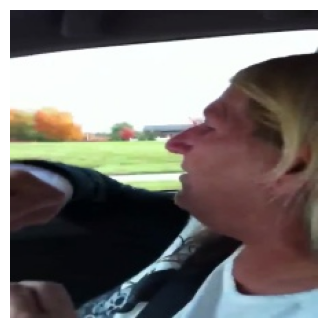


🔊 AUDIO:


In [52]:


# -------------------------------------------------------------------
# 4. Display the FIRST valid frame
# -------------------------------------------------------------------
if valid_frames:
    img = PILImage.open(io.BytesIO(valid_frames[0])).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print("\n❌ No valid frames to display!")

# -------------------------------------------------------------------
# 5. Play audio if present
# -------------------------------------------------------------------
if isinstance(audio, (bytes, bytearray)):
    print("\n🔊 AUDIO:")
    display(Audio(audio, rate=16000))
else:
    print("\n⚠️ Audio not bytes:", type(audio))


In [53]:
for col in ["video_id", "caption", "image_jpegs", "audio_wav"]:
    assert col in df_all.columns, f"Missing column in VALOR data: {col}"

if cfg.max_clips is not None:
    print("max_clips will be applied after grouping by video_id")


## 8. Clip-Level Multi-Frame Dataset

In [54]:
from PIL import UnidentifiedImageError

class ValorMultiFrameDataset(Dataset):
    """Clip-level VALOR dataset (multi-frame, audio + caption) with robust decoding."""
    def __init__(
        self,
        df_all: pd.DataFrame,
        tokenizer,
        max_length: int = 96,
        frame_limit_per_clip: Optional[int] = None,
        max_clips: Optional[int] = None,
    ) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.frame_limit_per_clip = frame_limit_per_clip

        grouped = df_all.groupby("video_id")
        video_ids = list(grouped.groups.keys())
        random.shuffle(video_ids)

        if max_clips is not None:
            video_ids = video_ids[:max_clips]

        self.clips: List[Dict[str, Any]] = []
        total_frames = 0

        for vid in tqdm(video_ids, desc="Building clip index"):
            group = grouped.get_group(vid)

            # NOTE: using "image_jpegs" as in your code
            frames = list(group["image_jpegs"])
            audio = group["audio_wav"].iloc[0]
            caption = group["caption"].iloc[0]

            if frame_limit_per_clip is not None:
                frames = frames[:frame_limit_per_clip]

            total_frames += len(frames)

            # Just store raw bytes here, we’ll handle decode errors in __getitem__
            self.clips.append(
                {
                    "video_id": vid,
                    "frames": frames,   # list of jpeg bytes (or lists, we’ll deal later if needed)
                    "audio_wav": audio,
                    "caption": str(caption),
                }
            )

        print("Total clips (videos):", len(self.clips))
        print("Total raw frames stored:", total_frames)

        # Pre-tokenize captions
        self._tok: List[Dict[str, Any]] = []
        for clip in tqdm(self.clips, desc="Tokenizing captions"):
            text = clip["caption"]
            toks = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )
            input_ids = toks["input_ids"][0]
            attn = toks["attention_mask"][0]
            labels = input_ids.clone()
            labels[attn == 0] = -100
            self._tok.append(
                {
                    "input_ids": input_ids,
                    "attention_mask": attn,
                    "labels": labels,
                    "text": text,
                }
            )

        print("Total clips after tokenization:", len(self.clips))

    def __len__(self) -> int:
        return len(self.clips)

    @staticmethod
    def _decode_image(jpeg_bytes: bytes) -> PILImage.Image:
        return PILImage.open(io.BytesIO(jpeg_bytes)).convert("RGB")

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        clip = self.clips[idx]
        toks = self._tok[idx]

        frames: List[PILImage.Image] = []

        for cell in clip["frames"]:
            if cell is None:
                continue

            # If some rows store a list/tuple of bytes instead of a single blob
            if isinstance(cell, (list, tuple)):
                candidates = cell
            else:
                candidates = [cell]

            for b in candidates:
                if b is None:
                    continue
                try:
                    img = self._decode_image(b)
                    frames.append(img)
                except Exception:
                    # skip bad frames, don't crash the whole batch
                    continue

        # Fallback if everything failed: create a dummy black image
        if len(frames) == 0:
            dummy = PILImage.new("RGB", (224, 224), color="black")
            frames = [dummy]

        return {
            "video_id": clip["video_id"],
            "frames": frames,
            "audio_wav": clip["audio_wav"],
            "input_ids": toks["input_ids"],
            "attention_mask": toks["attention_mask"],
            "labels": toks["labels"],
            "caption": toks["text"],
        }


def valor_multiframe_collate(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    return {
        "video_ids": [b["video_id"] for b in batch],
        "frames": [b["frames"] for b in batch],
        "audio_wav": [b["audio_wav"] for b in batch],
        "input_ids": torch.stack([b["input_ids"] for b in batch], dim=0),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch], dim=0),
        "labels": torch.stack([b["labels"] for b in batch], dim=0),
        "captions": [b["caption"] for b in batch],
    }


## 9. Build Train / Val Datasets & DataLoaders

In [55]:

tokenizer = mm_module.llm.tokenizer

full_dataset = ValorMultiFrameDataset(
    df_all=df_all,
    tokenizer=tokenizer,
    max_length=cfg.max_caption_len,
    frame_limit_per_clip=cfg.frame_limit_per_clip,
    max_clips=cfg.max_clips,
)

num_clips = len(full_dataset)
num_val = max(1, int(num_clips * cfg.val_ratio))
num_train = num_clips - num_val
print(f"Total clips: {num_clips} -> train={num_train}, val={num_val}")

train_indices = list(range(num_train))
val_indices = list(range(num_train, num_clips))

train_subset = torch.utils.data.Subset(full_dataset, train_indices)
val_subset = torch.utils.data.Subset(full_dataset, val_indices)

global_batch_size = cfg.batch_size_per_gpu * max(1, torch.cuda.device_count())


Building clip index:   0%|          | 0/3307 [00:00<?, ?it/s]

Total clips (videos): 3307
Total raw frames stored: 3307


Tokenizing captions:   0%|          | 0/3307 [00:00<?, ?it/s]

Total clips after tokenization: 3307
Total clips: 3307 -> train=3142, val=165


In [56]:

train_loader = DataLoader(
    train_subset,
    batch_size=global_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    collate_fn=valor_multiframe_collate,
)

val_loader = DataLoader(
    val_subset,
    batch_size=global_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
    collate_fn=valor_multiframe_collate,
)

print(f"Batches per epoch: train={len(train_loader)}, val={len(val_loader)}")


Batches per epoch: train=786, val=42


In [57]:
batch = next(iter(train_loader))
print(len(batch["frames"]), len(batch["frames"][0]), batch["captions"][0])

4 1 A man is talking with a drill, and then he starts the drill.


## 10. Optimizer & LR Schedule

In [58]:

trainable_params = list(mm_module.get_trainable_params())
print("Trainable parameter count:", sum(p.numel() for p in trainable_params))

optimizer = AdamW(
    trainable_params,
    lr=cfg.learning_rate,
    weight_decay=cfg.weight_decay,
)

num_training_steps = len(train_loader) * cfg.num_epochs
warmup_steps = int(num_training_steps * cfg.warmup_ratio)
print(f"Total training steps: {num_training_steps}, warmup steps: {warmup_steps}")

def get_lr(step: int) -> float:
    if step < warmup_steps:
        return cfg.learning_rate * (step + 1) / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, num_training_steps - warmup_steps)
    progress = min(max(progress, 0.0), 1.0)
    return cfg.learning_rate * 0.5 * (1.0 + math.cos(math.pi * progress))


Trainable parameter count: 8406016
Total training steps: 2358, warmup steps: 235


## 11. Weights & Biases Init

In [59]:

wandb_run = wandb.init(
    project=cfg.wandb_project,
    name=cfg.wandb_run_name,
    entity=cfg.wandb_entity,
    config=asdict(cfg),
)

wandb.watch(mm_module.projector, log="all", log_freq=100)


## 12. Training & Evaluation Helpers

In [60]:

def sample_single_frame_per_clip(frames_batch: List[List[PILImage.Image]]) -> List[PILImage.Image]:
    """Randomly pick one frame per clip in the batch."""
    picked = []
    for frames in frames_batch:
        if len(frames) == 0:
            raise RuntimeError("Clip has zero frames; check VALOR data.")
        idx = random.randint(0, len(frames) - 1)
        picked.append(frames[idx])
    return picked


@torch.no_grad()
def evaluate_epoch(step: int) -> Dict[str, float]:
    mm_module.eval()
    total_loss = 0.0
    n_batches = 0

    all_samples = []

    for batch in tqdm(val_loader, desc=f"Eval @ step {step}", leave=False):
        images = sample_single_frame_per_clip(batch["frames"])

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = mm_module(
            images=images,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        loss = outputs["loss"]
        total_loss += loss.item()
        n_batches += 1

        if len(all_samples) < cfg.num_eval_samples:
            for img, cap in zip(images, batch["captions"]):
                if len(all_samples) >= cfg.num_eval_samples:
                    break
                try:
                    gen = mm_module.generate(
                        images=img,
                        prompt="Describe this video frame in one or two sentences:",
                        max_new_tokens=64,
                        temperature=0.7,
                    )
                except Exception as e:
                    gen = f"[GEN_ERROR: {e}]"
                all_samples.append(
                    {
                        "image": wandb.Image(img),
                        "gt_caption": cap,
                        "gen_caption": gen,
                    }
                )

    avg_loss = total_loss / max(1, n_batches)
    metrics = {"val_loss": avg_loss}

    if all_samples:
        table = wandb.Table(columns=["image", "gt_caption", "gen_caption"])
        for s in all_samples:
            table.add_data(s["image"], s["gt_caption"], s["gen_caption"])
        wandb.log({"eval_samples": table, "global_step": step})

    return metrics


## 13. Main Training Loop

In [61]:

global_step = 0
best_val_loss = math.inf

history = []

for epoch in range(cfg.num_epochs):
    print(f"\n===== Epoch {epoch+1}/{cfg.num_epochs} =====")
    mm_module.train()
    epoch_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        images = sample_single_frame_per_clip(batch["frames"])

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        lr = get_lr(global_step)
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        optimizer.zero_grad(set_to_none=True)

        outputs = mm_module(
            images=images,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        loss = outputs["loss"]
        loss.backward()

        torch.nn.utils.clip_grad_norm_(trainable_params, cfg.max_grad_norm)
        optimizer.step()

        step_loss = loss.item()
        epoch_loss += step_loss
        n_batches += 1
        global_step += 1

        if global_step % cfg.log_every == 0:
            avg_loss = epoch_loss / max(1, n_batches)
            wandb.log(
                {
                    "train_loss": step_loss,
                    "train_loss_avg": avg_loss,
                    "lr": lr,
                    "epoch": epoch + 1,
                    "global_step": global_step,
                }
            )

        if global_step % cfg.eval_every == 0:
            print(f"\n>>> Running evaluation at step {global_step} ...")
            val_metrics = evaluate_epoch(global_step)
            val_loss = val_metrics["val_loss"]
            wandb.log({**val_metrics, "global_step": global_step})

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_path = PHASE3_OUT_DIR / "best_phase3_valor_perceiver.pt"
                torch.save(
                    {
                        "step": global_step,
                        "epoch": epoch,
                        "model_state_dict": mm_module.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "cfg": asdict(cfg),
                    },
                    best_path,
                )
                print(f"[BEST] Saved new best checkpoint to {best_path} (val_loss={val_loss:.4f})")

    avg_epoch_loss = epoch_loss / max(1, n_batches)
    history.append({"epoch": epoch + 1, "avg_train_loss": avg_epoch_loss})
    print(f"Epoch {epoch+1} complete | avg_train_loss={avg_epoch_loss:.4f}")
    wandb.log({"epoch_train_loss": avg_epoch_loss, "epoch": epoch + 1, "global_step": global_step})

print("\n>>> Final evaluation after training ...")
final_metrics = evaluate_epoch(global_step)
wandb.log({**final_metrics, "global_step": global_step})

final_path = PHASE3_OUT_DIR / "final_phase3_valor_perceiver.pt"
torch.save(
    {
        "step": global_step,
        "epoch": cfg.num_epochs,
        "model_state_dict": mm_module.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "cfg": asdict(cfg),
    },
    final_path,
)
print(f"Saved final Phase‑3 checkpoint to {final_path}")



===== Epoch 1/3 =====


Train Epoch 1:   0%|          | 0/786 [00:00<?, ?it/s]


>>> Running evaluation at step 500 ...


Eval @ step 500:   0%|          | 0/42 [00:00<?, ?it/s]

[BEST] Saved new best checkpoint to /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase3_llm_valor_perceiver/valor_qwen2p5_phase3_perceiver_v1/best_phase3_valor_perceiver.pt (val_loss=3.1093)
Epoch 1 complete | avg_train_loss=3.3577

===== Epoch 2/3 =====


Train Epoch 2:   0%|          | 0/786 [00:00<?, ?it/s]


>>> Running evaluation at step 1000 ...


Eval @ step 1000:   0%|          | 0/42 [00:00<?, ?it/s]

[BEST] Saved new best checkpoint to /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase3_llm_valor_perceiver/valor_qwen2p5_phase3_perceiver_v1/best_phase3_valor_perceiver.pt (val_loss=3.0407)

>>> Running evaluation at step 1500 ...


Eval @ step 1500:   0%|          | 0/42 [00:00<?, ?it/s]

[BEST] Saved new best checkpoint to /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase3_llm_valor_perceiver/valor_qwen2p5_phase3_perceiver_v1/best_phase3_valor_perceiver.pt (val_loss=2.9952)
Epoch 2 complete | avg_train_loss=2.9903

===== Epoch 3/3 =====


Train Epoch 3:   0%|          | 0/786 [00:00<?, ?it/s]


>>> Running evaluation at step 2000 ...


Eval @ step 2000:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3 complete | avg_train_loss=3.0025

>>> Final evaluation after training ...


Eval @ step 2358:   0%|          | 0/42 [00:00<?, ?it/s]

Saved final Phase‑3 checkpoint to /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase3_llm_valor_perceiver/valor_qwen2p5_phase3_perceiver_v1/final_phase3_valor_perceiver.pt


## 14. Save History & Quick Inference Helper

In [62]:

history_path = PHASE3_OUT_DIR / "train_history_phase3_valor_perceiver.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)
print("Saved training history to:", history_path)

if wandb_run is not None:
    wandb_run.finish()
    print("Closed W&B run.")

def debug_generate_for_clip(idx: int = 0, prompt: str = "Describe this video frame:") -> Dict[str, Any]:
    mm_module.eval()
    clip = full_dataset.clips[idx]
    frames = [ValorMultiFrameDataset._decode_image(b) for b in clip["frames"]]
    img = random.choice(frames)

    gen = mm_module.generate(
        images=img,
        prompt=prompt,
        max_new_tokens=96,
        temperature=0.7,
    )
    return {
        "video_id": clip["video_id"],
        "image": img,
        "caption_gt": clip["caption"],
        "caption_gen": gen,
    }

print("You can now call `debug_generate_for_clip(0)` in the notebook to inspect a sample.")


Saved training history to: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase3_llm_valor_perceiver/valor_qwen2p5_phase3_perceiver_v1/train_history_phase3_valor_perceiver.json


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▁▁
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▂▄▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▄▄▄▅▄▃▆▁▃▁▃▅▄▂▃▃▃▄▄▂▄▁▂▂▂▂▂▂▂▃▂▄▂▁▃▂▂▂▄
train_loss_avg,██▇▇▆▆▅▅▄▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▁
epoch,3
epoch_train_loss,3.00255
global_step,2358
lr,0.0


Closed W&B run.
You can now call `debug_generate_for_clip(0)` in the notebook to inspect a sample.


In [66]:
@torch.no_grad()
def inference(
    self,
    image=None,
    audio=None,
    text=None,
    max_new_tokens=128,
    temperature=0.7,
):
    """
    Unified inference:
      - image → image encoder → projector → LLM
      - audio → audio encoder → projector → LLM
      - text → direct LLM (no alignment step)
      - multimodal mixes → combine embeddings
    """

    device = self.device

    # -------------------------------------------------------
    # 1. Encode whatever modalities are present
    # -------------------------------------------------------
    embeds = []

    if image is not None:
        img_features = self.encode_image(image.to(device))
        embeds.append(img_features)

    if audio is not None:
        aud_features = self.encode_audio(audio.to(device))
        embeds.append(aud_features)

    # -------------------------------------------------------
    # 2. Fuse embeddings (mean pool for now)
    # -------------------------------------------------------
    if len(embeds) > 0:
        fused = torch.stack(embeds).mean(dim=0)
    else:
        fused = None

    # -------------------------------------------------------
    # 3. Generate based on modality availability
    # -------------------------------------------------------
    if fused is not None:
        # Multimodal → goes through projector → LLM
        projected = self.projector(fused)
        output = self.llm.generate(
            inputs_embeds=projected,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
        )
    else:
        # Pure text → directly LLM
        if text is None:
            raise ValueError("No modality provided!")
        output = self.llm.generate(
            prompt=text,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
        )

    return output


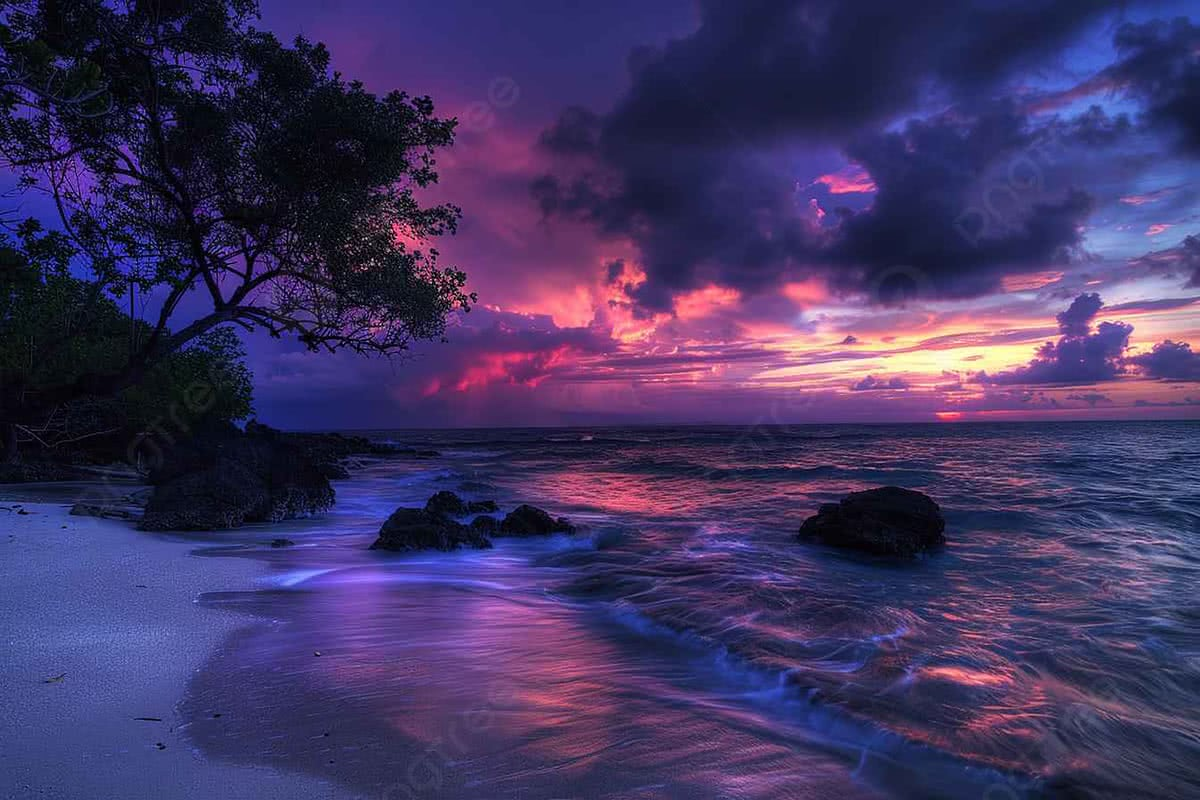

In [72]:
from PIL import Image
img = "/home/hice1/vchopra37/scratch/projects/edge_glass/temp.jpg"

image = Image.open(img)
image


In [73]:
mm_module.inference(image=age, text="Describe this frame.")

AttributeError: 'MultimodalLLM' object has no attribute 'inference'